In [1]:
from hough_functions import LineDetector
from ultralytics import YOLO
import csv
import cv2

In [2]:
def calculate_x_val(line, y):
    '''
    :param line: Coordinates [[x1, y1, x2, y2]] that define a line.
    :param y: Y value of the bottom of a detected object.
    :return: X value where object intercepts the line.
    '''
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    slope = (y2 - y1) / (x2 - x1)
    x = (y - y1)/slope + x1
    return x

def calculate_distance(w0, w1, d0):
    '''
    :param w0: Width of the track in pixels at the edge of the screen (bottom)
    :param w1: Width of the track in pixels at the bottom of the detected object
    :param d1: Distance from the camera to w0 (in Feet)
    :return: Distance to w1
    '''
    return d0 * (w0/w1)

def height_width(image):
    '''
    :param image: An image imported through cv2.imread()
    :return: Two ints representing the height and width of the image in pixels respectively
    '''
    return image.shape[:2]

In [4]:
location = 'ana.png'

In [5]:
##########################

# Detect objects and lines

##########################

image = cv2.imread(location)
#model = YOLO('yolov8n.pt')
#results = model(location)
detector = LineDetector()
lines = detector.detect_lines_image(location, crop=True)


image 1/1 /home/matteo/Projects/Intramotev/YOLOv8_Hough_Combine/ana.png: 384x640 1 train, 94.1ms
Speed: 6.3ms preprocess, 94.1ms inference, 20.9ms postprocess per image at shape (1, 3, 384, 640)
Line Detected with equation x = (y - 1691) / 0.0 + 1202
Line Detected with equation x = (y - 1130) / 3.7333333333333334 + 1579
Line Detected with equation x = (y - 1107) / 3.4850299401197606 + 1580
Line Detected with equation x = (y - 1690) / -3.7401574803149606 + 1270
Line Detected with equation x = (y - 1450) / -3.4646464646464645 + 1318
Line Detected with equation x = (y - 1231) / 2.9285714285714284 + 1634
Line Detected with equation x = (y - 1247) / -3.057142857142857 + 1359
Line Detected with equation x = (y - 1683) / -3.744 + 1271
Line Detected with equation x = (y - 947) / 0.0 + 1432
Line Detected with equation x = (y - 1126) / 3.774193548387097 + 1579
Line Detected with equation x = (y - 1378) / 2.9125 + 1683
Line Detected with equation x = (y - 1306) / -3.4731182795698925 + 1360


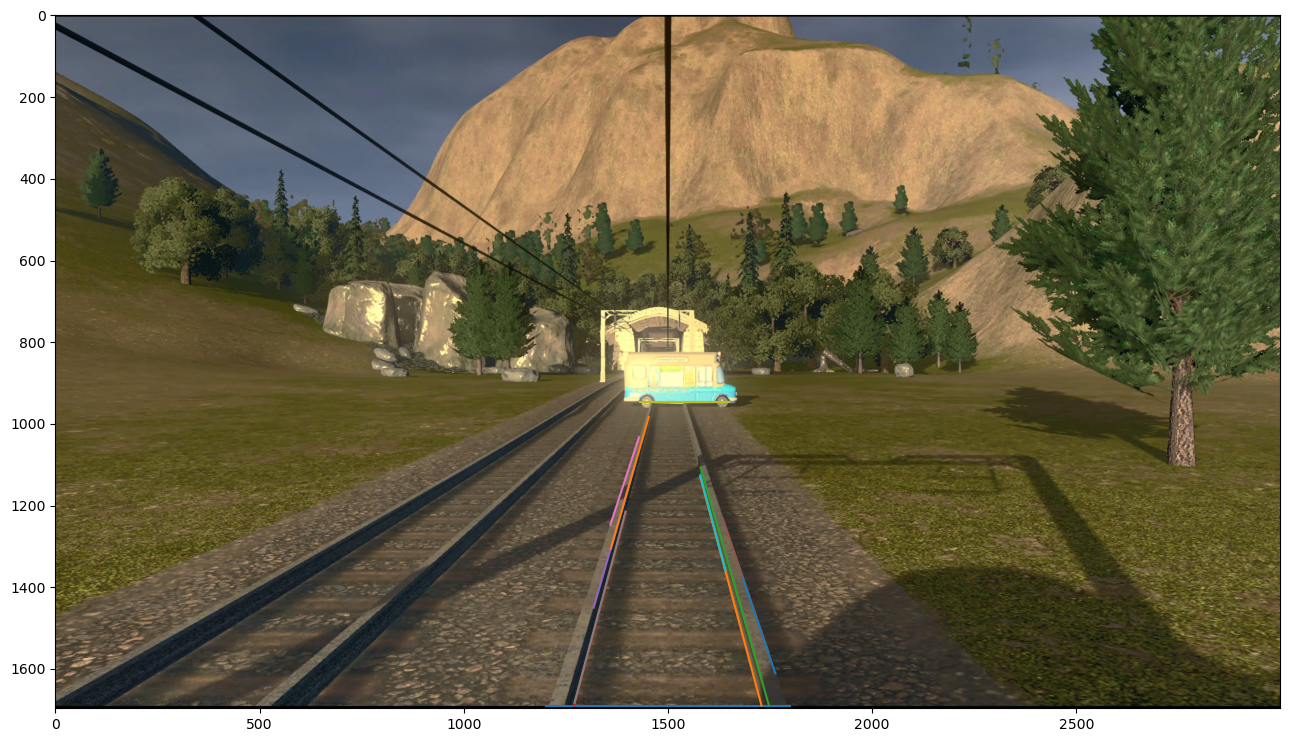

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize = (16,9))

for line in lines:
    
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    
    plt.plot([x1,x2],[y1,y2])
    
ana = Image.open(location)
plt.imshow(ana)
plt.show()

# use kmeans clustering to group the lines on the left track, right track, and horizontal lines
# take the average of the lines for the left track, 
# take the average of the lines for the right track
# remove the horiziontal lines
# use averaged lines for left and right as the lines of the tracks for calculation

In [5]:
##########################

# Loop through objects
# Calculate Distance
# Save to CSV

##########################

detected_objects = results[0].boxes
csv_file_name = 'detected_objects.csv'
object_names = results[0].names
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(['Class ID', 'Object Name','Confidence', 'X1', 'Y1', 'X2', 'Y2','Distance'])

    for box in detected_objects:
        class_id = box.cls[0].item()
        conf = box.conf[0].item()
        cords = box.xyxy[0].tolist()  # formatted as [x1, y1, x2, y2]
        object_name = object_names.get(class_id, 'Unknown')
        
        ##########################

        # Calculate Distance

        ##########################

        image_height = height_width(image)[0]
        bottom_object = cords[3]
        x1 = calculate_x_val(lines[0], bottom_object)
        x2 = calculate_x_val(lines[1], bottom_object)
        x11 = calculate_x_val(lines[0], image_height)
        x22 = calculate_x_val(lines[1], image_height)
        # Final distance value
        distance = calculate_distance((x22-x11), (x2-x1), 10)
        
        ##########################

        # Write to CSV

        ##########################       
        
        # Write the object data to the CSV file
        writer.writerow([class_id, object_name, conf, *cords, distance])



In [6]:
##########################

# Display Picture

##########################

detected_objects = results[0].boxes
object_names = results[0].names

# Draw bounding boxes on the image
for box in detected_objects:
    # Extract box coordinates
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    # Convert coordinates to integers
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    # Get class ID and confidence
    class_id = box.cls[0].item()
    conf = box.conf[0].item()
    # Get object name
    object_name = object_names.get(class_id, 'Unknown')
    # Draw bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put text showing class name and confidence
    cv2.putText(image, f'{object_name}: {conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(image, f'Distance: {distance:.2f}', (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
cv2.imwrite('processed_image.jpg', image)

True